In [11]:
# import relevant libraries
import pandas
import numpy
from operator import itemgetter
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### Let's take a look at the train data

In [12]:
# read train data
train_df = pandas.read_csv('./sonar_train.csv')
# display first 5 rows
train_df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A52,A53,A54,A55,A56,A57,A58,A59,A60,Class
0,0.0079,0.0086,0.0055,0.0250,0.0344,0.0546,0.0528,0.0958,0.1009,0.1240,...,0.0176,0.0127,0.0088,0.0098,0.0019,0.0059,0.0058,0.0059,0.0032,R
1,0.0599,0.0474,0.0498,0.0387,0.1026,0.0773,0.0853,0.0447,0.1094,0.0351,...,0.0013,0.0005,0.0227,0.0209,0.0081,0.0117,0.0114,0.0112,0.0100,M
2,0.0093,0.0269,0.0217,0.0339,0.0305,0.1172,0.1450,0.0638,0.0740,0.1360,...,0.0212,0.0091,0.0056,0.0086,0.0092,0.0070,0.0116,0.0060,0.0110,R
3,0.0151,0.0320,0.0599,0.1050,0.1163,0.1734,0.1679,0.1119,0.0889,0.1205,...,0.0061,0.0015,0.0084,0.0128,0.0054,0.0011,0.0019,0.0023,0.0062,R
4,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R


### Let's take a look at the test data

In [13]:
# read test data
test_df = pandas.read_csv('./sonar_test.csv')
# display first 5 rows
test_df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A52,A53,A54,A55,A56,A57,A58,A59,A60,Class
0,0.0125,0.0152,0.0218,0.0175,0.0362,0.0696,0.0873,0.0616,0.1252,0.1302,...,0.0041,0.0074,0.0030,0.0050,0.0048,0.0017,0.0041,0.0086,0.0058,R
1,0.0530,0.0885,0.1997,0.2604,0.3225,0.2247,0.0617,0.2287,0.0950,0.0740,...,0.0244,0.0199,0.0257,0.0082,0.0151,0.0171,0.0146,0.0134,0.0056,M
2,0.0368,0.0279,0.0103,0.0566,0.0759,0.0679,0.0970,0.1473,0.2164,0.2544,...,0.0105,0.0024,0.0018,0.0057,0.0092,0.0009,0.0086,0.0110,0.0052,M
3,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R
4,0.0216,0.0124,0.0174,0.0152,0.0608,0.1026,0.1139,0.0877,0.1160,0.0866,...,0.0052,0.0049,0.0096,0.0134,0.0122,0.0047,0.0018,0.0006,0.0023,R


### Let's break the data into input features and output variable to predict

In [14]:
# target that we want to classify things into
targets = ['Class']

# Separate out the features and target data in both train and test
y_train = train_df[targets]
x_train = train_df.drop(columns = targets) 

# Now let's do it for test data
y_test = test_df[targets]
x_test = test_df.drop(columns = targets) 

### Let's add function for mionkowski distance 

In [15]:
# Calculates mionkowski distance - the exact distance metrics depend on q
def mionkowski_distance(vector1, vector2, q):
    assert( len(vector1) == len(vector2))
    return numpy.sum( numpy.power( numpy.array(vector1) - numpy.array(vector2), q ) ) ** (1/q)


### Let's define KD Tree now, we will use KD Tree for nearest neighbors algorithm

In [16]:
class KDTree:
    
    # Inner class to represent node of KDTree
    class __node:
        # Constructor
        def __init__(self, left_child, right_child, value):
            # Left child of this node
            self.left_child = left_child
            # Right child of this node
            self.right_child = right_child
            # Value for this node
            self.value = value
    
    # Constructor
    def __init__(self, all_points ):
        # Set the dimension of each data row
        self.__k = len( all_points[0] )
        # Build the tree and initialize the root
        self.__root = self.__build(list(all_points), 0)
    
    # Build the tree
    def __build(self, all_points, depth):
        # If dimension of data rows is zero, we do not build anything as there is no data
        if self.__k == 0:
            return None
        
        # If there are not data points left, we return None, which is null leaf node
        if len(all_points) == 0:
            return None
        
        # Sorts the array by item that lies at depth%k
        all_points.sort( key = itemgetter(depth % self.__k) )
        # Get median point
        median_index = len(all_points)//2
        # Create left child at depth + 1
        left_child =  self.__build( all_points[:median_index], depth+1 )
        # Create right child at depth + 1
        right_child = self.__build( all_points[median_index+1:], depth+1 )
        # Root node at this depth with value at median index
        root = self.__node( left_child = left_child, right_child = right_child, 
            value = all_points[median_index])
        # return the generate root
        return root
    
    # Exposes the root of tree to users of this class
    def get_root(self):
        return self.__root

### Implement nearest neighbour algorithm

In [17]:
class NearestNeighbors:
    
    # Constructor
    def __init__(self, q=2):
        # q - parameter to control the mionkowski distance
        self.__q = q
        # Reset the state
        self.__reset(kdtree=None, k=None)
    
    # Resets the state before we start the search of node
    def __reset(self, kdtree, k):
        # Set dimension of each data point
        self.__k = k
        # Set the kdtree root node
        self.__kdtree = kdtree
        # Initialize closest neighbor to null, as search begins
        self.__closest_neighbor = None
        # Initialize closest best_distance to null, as search begins
        self.__best_distance = None
    
    # Searches for nearest neighbor in the kd-tree
    def __search(self, kdtree_node, point, depth=0):
        if kdtree_node is None:
            return None
        
        # calculate the distance
        distance = mionkowski_distance(kdtree_node.value, point, q=self.__q)
        
        # if this distance is better than what we have so far, let's update the closest neighbor
        if ( self.__closest_neighbor is None ) or ( distance < self.__best_distance ):
            # update the state of our search
            self.__closest_neighbor = kdtree_node.value
            self.__best_distance = distance
            
        # Next we go down in the tree, to look for better neighbors
        median_index = depth % self.__k
        # Difference between median node value and the input point
        difference_in_values = point[median_index] - kdtree_node.value[median_index]
        if difference_in_values <= 0:
            # Let's look at the left side first
            self.__search(kdtree_node.left_child, point, depth+1)
            if (difference_in_values**2) < self.__best_distance:
                # worth trying on the right neighbor as well!
                self.__search(kdtree_node.right_child, point, depth+1)
        else:
            # Let's look at the right side first
            self.__search(kdtree_node.right_child, point, depth+1)
            if (difference_in_values**2) < self.__best_distance:
                # worth trying on the left neighbor as well!
                self.__search(kdtree_node.left_child, point, depth+1)
    
    # Fits the x_train and y_train
    def fit(self, x_train, y_train):
        # Extract arrays
        xs = x_train.values
        ys = y_train.values
        
        # We use this map to later predict class of the neighbor that is nearest to test point
        self.__xtrain_to_y = {}
        for index in range(len(xs)):
            self.__xtrain_to_y[str(xs[index])] = ys[index]
        
        # Start the kd tree
        self.__kdtree_root = KDTree(xs).get_root()
    
    # Predict the values for test data
    def predict(self, x_test):
        # we must call fit() first
        if self.__kdtree_root is None:
            raise RuntimeError('Please fit values first!')
            
        xs = x_test.values
        all_predictions = []
        for index in range(len(xs)):
            # reset the state
            self.__reset(self.__kdtree_root, len(xs[0]))
            # search for the node
            self.__search( self.__kdtree_root, xs[index] )
            # predict the class
            predicted_class = self.__xtrain_to_y[ str(self.__closest_neighbor) ]
            # add to our list
            all_predictions.append(predicted_class[0])
        
        # return all predictions
        return all_predictions


### Let's run things now!

In [18]:
def run(q):
    # initialize nearest neighbor
    nn = NearestNeighbors(q)
    # fit the data
    nn.fit(x_train, y_train)
    # predict for test data
    preds = nn.predict(x_test)
    
    # calculate the stats
    y_test_arr = y_test['Class'].values
    # print classification report
    print(classification_report(preds , y_test_arr))
    # show the heatmap for confusion matrix
    sns.heatmap(pandas.DataFrame(confusion_matrix(preds , y_test_arr)) , cmap="viridis" , annot = True)

### Using q = 1

              precision    recall  f1-score   support

           M       0.59      0.65      0.62        34
           R       0.62      0.57      0.60        35

    accuracy                           0.61        69
   macro avg       0.61      0.61      0.61        69
weighted avg       0.61      0.61      0.61        69



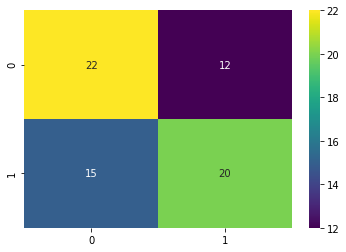

In [19]:
# Run for q = 1, Manhattan distance
run(q=1)

#### What do we notice for q= 1?
### Accuracy : 61%
### Sensitivity  : 65% ( w.r.t. class 'M' )
### Specificity : 57%  ( w.r.t. class 'M' )
### Precision   : 59% ( w.r.t. class 'M' ) 

              precision    recall  f1-score   support

           M       0.97      0.86      0.91        42
           R       0.81      0.96      0.88        27

    accuracy                           0.90        69
   macro avg       0.89      0.91      0.90        69
weighted avg       0.91      0.90      0.90        69



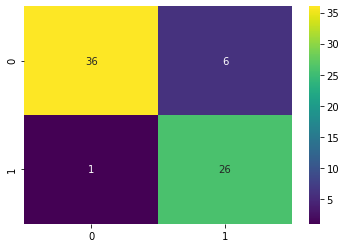

In [20]:
# Run for q = 2, Euclidean distance
run(q=2)


#### What do we notice for q= 2?
### Accuracy : 90%
### Sensitivity  : 86% ( w.r.t. class 'M' )
### Specificity : 96% ( w.r.t. class 'M' )
### Precision   : 97% ( w.r.t. class 'M' ) 

#### For this specific dataset we can see that Euclidean distance is a better option because : 
### It has a higher accuracy sensitivity, specificity and precision 
### The run time is not signifcant and does not need to be reduced 
### Manhattan distance is a lot more useful when Euclidean distance would be computationally too expensive to calculate
